Short data analysis for the recipe data found at:
https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews?select=recipes.csv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

reviews = pd.read_csv('drive/MyDrive/CS3891/Data/reviews.csv')
recipes = pd.read_csv('drive/MyDrive/CS3891/Data/recipes.csv')

recipes.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   ReviewId       1401982 non-null  int64 
 1   RecipeId       1401982 non-null  int64 
 2   AuthorId       1401982 non-null  int64 
 3   AuthorName     1401982 non-null  object
 4   Rating         1401982 non-null  int64 
 5   Review         1401768 non-null  object
 6   DateSubmitted  1401982 non-null  object
 7   DateModified   1401982 non-null  object
dtypes: int64(4), object(4)
memory usage: 85.6+ MB


In [ ]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

In [ ]:
# Check out all columns
print(reviews.columns)

# Make a histogram of recipe categories
reviews['Rating'].value_counts()

Index(['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review',
       'DateSubmitted', 'DateModified'],
      dtype='object')


5    1012082
4     229217
0      76248
3      50279
2      17597
1      16559
Name: Rating, dtype: int64

In [ ]:
average_ratings = reviews.groupby('RecipeId', as_index=False)['Rating'].mean()
average_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271678 entries, 0 to 271677
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   RecipeId  271678 non-null  int64  
 1   Rating    271678 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 4.1 MB


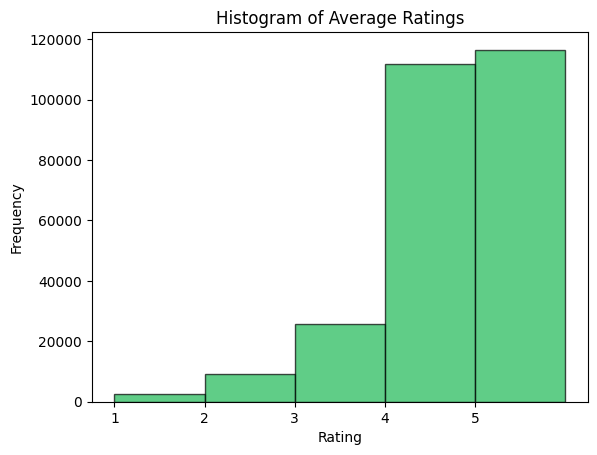

In [ ]:
plt.hist(average_ratings['Rating'], bins=range(1, 7), edgecolor='black', color= "#1DB954", alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Average Ratings')
plt.xticks(range(1, 6))  # Assuming ratings are integers from 1 to 5
plt.show()

In [ ]:
from scipy.sparse import csr_matrix
import numpy as np

reviews_df = reviews

# Map IDs to indices
user_ids = reviews_df['AuthorId'].astype('category').cat.codes
recipe_ids = reviews_df['RecipeId'].astype('category').cat.codes

# Create the sparse matrix
sparse_matrix = csr_matrix((reviews_df['Rating'], (recipe_ids, user_ids)), shape=(recipe_ids.max() + 1, user_ids.max() + 1))

from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
# Note: Depending on your dataset size, this might still be a heavy operation
similarity_matrix = cosine_similarity(sparse_matrix, dense_output=False)

[20608, 70396, 70254, 52290, 75271]


In [ ]:
def recommend_recipes(user_index, similarity_matrix, sparse_matrix, top_n=5):
    # Find all recipes the user has rated
    rated_recipes = sparse_matrix[:, user_index].nonzero()[0]

    # Sum similarities for all recipes the user has rated
    similarity_scores = similarity_matrix[rated_recipes].sum(axis=0)

    # Convert to dense format and get rid of the original user's ratings
    similarity_scores = np.array(similarity_scores).flatten()
    similarity_scores[rated_recipes] = 0

    # Get the indices of the top N recommendations
    recommended_recipe_indices = similarity_scores.argsort()[-top_n:][::-1]

    return recommended_recipe_indices

# Example usage:
user_index = 2046  # Example user index
recommendations = recommend_recipes(user_index, similarity_matrix, sparse_matrix, top_n=5)

# Translate back to recipe IDs if necessary
inverse_recipe_mapping = dict(enumerate(reviews_df['RecipeId'].astype('category').cat.categories))
recommended_recipe_ids = [inverse_recipe_mapping[idx] for idx in recommendations]

print(recommended_recipe_ids)

[178111, 107174, 94722, 389955, 108522]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Assuming reviews_df is your DataFrame with columns 'AuthorId', 'RecipeId', and 'Rating'

# Create a sparse matrix (recipes x users)
user_ids = reviews_df['AuthorId'].astype('category').cat.codes
recipe_ids = reviews_df['RecipeId'].astype('category').cat.codes
sparse_matrix = csr_matrix((reviews_df['Rating'], (recipe_ids, user_ids)), shape=(recipe_ids.max() + 1, user_ids.max() + 1))

# Transpose the matrix to make it users x recipes, suitable for user-based CF
user_recipe_matrix = sparse_matrix.T

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_recipe_matrix, dense_output=False)

In [ ]:
# For a given user, recommend recipes based on similar users
def recommend_for_user(user_index, user_similarity, sparse_matrix, top_n=5):
    # Get top N similar users to the given user (excluding the user itself)
    similarity_scores = user_similarity[user_index].toarray().flatten()
    similarity_scores[user_index] = -1  # Exclude self-similarity
    similar_users = similarity_scores.argsort()[-top_n:]

    # Aggregate the recipes rated by these similar users, weighted by similarity
    similar_users_matrix = sparse_matrix[:, similar_users]
    recipe_scores = similar_users_matrix.dot(similarity_scores[similar_users].reshape(-1, 1))

    # Recommend recipes with the highest aggregated scores that the user hasn't rated
    user_rated_recipes = sparse_matrix[:, user_index].nonzero()[0]
    recipe_scores[user_rated_recipes] = -1  # Exclude already rated recipes
    recommended_recipes = recipe_scores.ravel().argsort()[-top_n:]

    return recommended_recipes

# Example: Assuming you have a way to map user_index back to AuthorId
user_index = 2046  # Replace with the actual user index you're interested in
recommendations = recommend_for_user(user_index, user_similarity, sparse_matrix, top_n=5)
recommendation_name = recipes.loc[recipes['RecipeId'].isin(recommendations), "Name"]
print(recommendations)
print(recommendation_name)


[ 90586  90587  90574 271677  36525]
32874     Broccoli Casserole for kids!!!!
85398        Better-than-a-candy-bar Cake
85410                        Quick Paella
85411               Honey Sponge Cupcakes
261179          Chinese Chicken Casserole
Name: Name, dtype: object


In [ ]:
reviews.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [ ]:
recipes_2046 = reviews[reviews['AuthorId'] == 2046][['RecipeId', 'Rating']]
names_2046 = recipes.loc[recipes['RecipeId'].isin(recipes_2046['RecipeId']), ["RecipeId", "Name"]]
combined_2046 = names_2046.merge(recipes_2046, on='RecipeId', how='left')
print(combined_2046)

   RecipeId                                              Name  Rating
0       517                            Greek Stuffed Meatloaf       5
1      3431                   Leek, Tomato, Goat Cheese Pizza       5
2      4038                        Easy Pumpkin Bread Pudding       2
3      4523     Chinese Imperial Palace General Tso's Chicken       2
4      4684              Flank Steak With Lime-Chipotle Sauce       5
5      5221                      Spinach and Strawberry Salad       4
6      5344           Marinated Flank Steak with Citrus Salsa       4
7     13307  Neiman-Marcus $250 Chocolate Chip Cookies Recipe       5


In [ ]:
# Basic clustering on just a few different recipes that a user could like
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity

N = 5

random_recipes = recipes.sample(N)

random_recipes.head()

import pandas as pd

from sklearn.neighbors import NearestNeighbors

from scipy.sparse import csr_matrix

# Map user and recipe IDs to matrix indices
user_ids = reviews['AuthorId'].unique()
recipe_ids = reviews['RecipeId'].unique()
user_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
recipe_to_index = {recipe_id: index for index, recipe_id in enumerate(recipe_ids)}

# Create the sparse matrix
row_indices = reviews['AuthorId'].map(user_to_index)
col_indices = reviews['RecipeId'].map(recipe_to_index)
data = reviews['Rating']
rating_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(len(user_ids), len(recipe_ids)))

# Step 1: Create a user-item rating matrix
rating_matrix = reviews.pivot_table(index='AuthorId', columns='RecipeId', values='Rating')

# Fill missing values with zeros
rating_matrix_filled = rating_matrix.fillna(0)

# Step 2: Use NearestNeighbors to find similar users
# Using cosine similarity as the metric
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
knn.fit(rating_matrix)

# Example: Finding recommendations for a user (replace `user_id` with the actual user ID)
user_id = 337963  # Random user ID I chose
user_index = rating_matrix.index.get_loc(user_id)

# Finding the k-nearest neighbors
distances, indices = knn.kneighbors([rating_matrix_filled.iloc[user_index]], n_neighbors=6)
similar_users_indices = indices[0][1:]  # Exclude the first one (the user itself)

# Step 3: Recommend recipes based on similar users' preferences
# Aggregate the ratings from similar users and recommend the top-rated recipes
similar_users_ratings = rating_matrix_filled.iloc[similar_users_indices]
recommended_recipes = similar_users_ratings.mean(axis=0).sort_values(ascending=False)

# Filter out recipes the user has already rated
unrated_recipes = recommended_recipes[rating_matrix.loc[user_id].isna()]

# Recommend the top 5 unrated recipes
top_recommendations = unrated_recipes.head(5)
print(top_recommendations)


AttributeError: 'csr_matrix' object has no attribute 'index'